In [1]:
from sktime.datasets import load_airline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
air_passengers = load_airline()

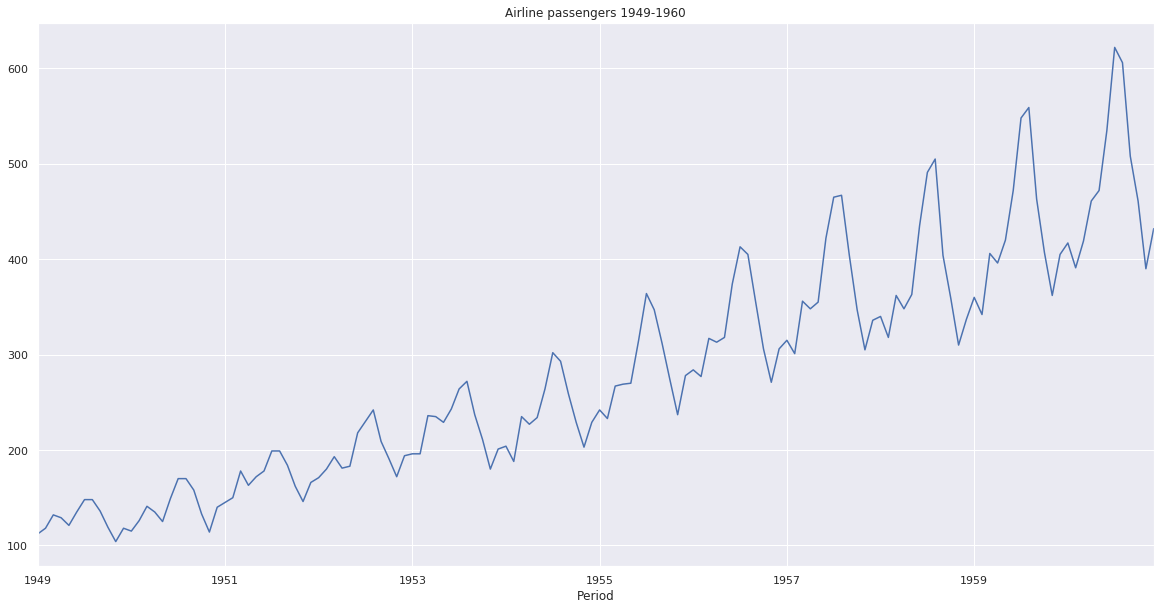

In [214]:
sns.set_theme()
air_passengers.plot(title='Airline passengers 1949-1960')
plt.savefig('img/air_passengers.png', bbox_inches='tight')
plt.show()

In [4]:
air_passengers

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
           ...  
1960-08    606.0
1960-09    508.0
1960-10    461.0
1960-11    390.0
1960-12    432.0
Freq: M, Name: Number of airline passengers, Length: 144, dtype: float64

In [5]:
y_train = air_passengers[air_passengers.index < '1959-01']
y_test  = air_passengers[air_passengers.index >= '1959-01']

# ChatGPT 1

In [6]:
#!pip install openai

In [7]:
import openai
import os
import json

openai.api_key = os.getenv('OPENAI_API_KEY')

In [8]:
print(air_passengers.to_string())

Period
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
1949-06    135.0
1949-07    148.0
1949-08    148.0
1949-09    136.0
1949-10    119.0
1949-11    104.0
1949-12    118.0
1950-01    115.0
1950-02    126.0
1950-03    141.0
1950-04    135.0
1950-05    125.0
1950-06    149.0
1950-07    170.0
1950-08    170.0
1950-09    158.0
1950-10    133.0
1950-11    114.0
1950-12    140.0
1951-01    145.0
1951-02    150.0
1951-03    178.0
1951-04    163.0
1951-05    172.0
1951-06    178.0
1951-07    199.0
1951-08    199.0
1951-09    184.0
1951-10    162.0
1951-11    146.0
1951-12    166.0
1952-01    171.0
1952-02    180.0
1952-03    193.0
1952-04    181.0
1952-05    183.0
1952-06    218.0
1952-07    230.0
1952-08    242.0
1952-09    209.0
1952-10    191.0
1952-11    172.0
1952-12    194.0
1953-01    196.0
1953-02    196.0
1953-03    236.0
1953-04    235.0
1953-05    229.0
1953-06    243.0
1953-07    264.0
1953-08    272.0
1953-09    237.0
1953-10    211.0
1953-11

In [9]:
horizon = 24

In [203]:
def chat_gpt_forecast(data,
                      horizon,
                      time_idx='Period', 
                      forecast_col = 'Forecast',
                      model="gpt-3.5-turbo",
                      verbose=False):
    
    prompt = f""" 
    Given the dataset delimited by the triple backticks, 
    forecast next {horizon} values of the time series. 

    Return the answer in JSON format, containing two keys: '{time_idx}' 
    and '{forecast_col}', and list of values assigned to them. 
    Return only the forecasts, not the Python code.

    ``` {data.to_string()}``` 
    """
    
    if verbose:
        print(prompt)
    
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, 
    )
    
    output = response.choices[0].message["content"]
    
    try:
        json_object = json.loads(output)
        df = pd.DataFrame(json_object)
        df[time_idx] = df[time_idx].astype(data.index.dtype)
    except:
        df = output
        print(output)
    
    return df

In [204]:
gpt_forecast = chat_gpt_forecast(y_train, horizon)

In [205]:
gpt_forecast

,Period,Forecast
0,1959-01,360.0
1,1959-02,340.0
2,1959-03,385.0
3,1959-04,375.0
4,1959-05,375.0
5,1959-06,435.0
6,1959-07,490.0
7,1959-08,505.0
8,1959-09,435.0
9,1959-10,385.0


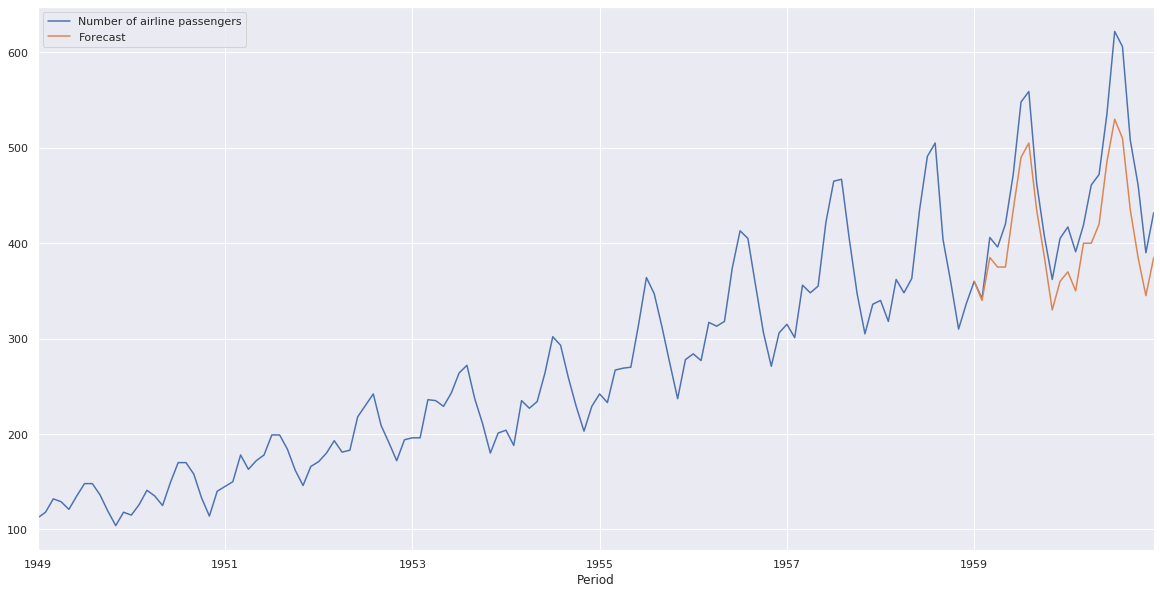

In [213]:
y = air_passengers.reset_index()
y.merge(gpt_forecast, how='outer').plot(x='Period', y=['Number of airline passengers', 'Forecast'])
plt.savefig('img/chatgpt_1_chart.png', bbox_inches='tight')

## Fake data

In [156]:
import numpy as np
from typing import Tuple, List

def get_champagne(years: Tuple[int, int] = (2018, 2023),
                  normal_days: dict =  {'n': 1000, 'p': 0.02},
                  weekdays: dict = {4: {'n': 1800, 'p': 0.03},
                                    5: {'n': 2000, 'p': 0.05}},
                  special_events: dict = {(29, 12): {'n': 1500, 'p': 0.1},
                                          (30, 12): {'n': 2000, 'p': 0.2},
                                          (31, 12): {'n': 2000, 'p': 0.7}},
                 trend=.01,
                 seas_months=[6, 7, 8],
                 seas_coef=1.2):
    """Model for sparkling wine demand"""
    df = pd.DataFrame({
        'date': pd.date_range(f'{years[0]}-01-01', f'{years[1]}-12-31')    
    })
    
    df['weekday'] =  df['date'].dt.weekday
    df['monthday'] =  df['date'].dt.day
    df['month'] =  df['date'].dt.month
    df['week'] =  df['date'].dt.strftime('%U')
    df['year'] =  df['date'].dt.year
    
    normal_days_amount = np.random.binomial(**normal_days, size=len(df))
    df['amount'] = normal_days_amount
    
    # Trend
    df['amount'] += np.array(df.index.values) * trend
    df['amount'] = df['amount'].astype(int)
    
    if weekdays:
        for wd, params in weekdays.items():
            mask = df.weekday == wd
            df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
    
    if special_events:
        for d, params in special_events.items():
            mask = (df.monthday == d[0]) & (df.month == d[1]) 
            df.loc[mask, 'amount'] = np.random.binomial(**params, size=mask.sum())
            col_name = f'special_event_{d[0]}_{d[1]}'
            df[col_name] = 0
            df.loc[mask, col_name] = 1
    
    # Aggregation
    df = df[['year', 'month', 'amount']]
    df = df.groupby(['year', 'month']).sum()
    
    # Create period date
    period = df\
        .reset_index() \
        .apply(lambda x: pd.Period(f"{x['year']}-{x['month']}", freq='M'), axis=1)
    
    df['period'] = period.tolist()
    df = df.reset_index()
    
    # Adding seasonality
    df.loc[df.month.isin(seas_months), 'amount'] *= seas_coef
    df['amount'] = df['amount'].astype(int)
    
    return df[['period', 'amount']]

In [180]:
START_YEAR = 2015
END_YEAR = 2023
SPLIT_DATE = '2022-12-31'

np.random.seed(7)

data = get_champagne(years=(START_YEAR, END_YEAR),
                    special_events={(31, 12): {'n': 2000, 'p': 0.7}})

In [181]:
data

,period,amount
0,2015-01,1198
1,2015-02,996
2,2015-03,1109
3,2015-04,1076
4,2015-05,1194
...,...,...
103,2023-08,2085
104,2023-09,1806
105,2023-10,1803
106,2023-11,1848


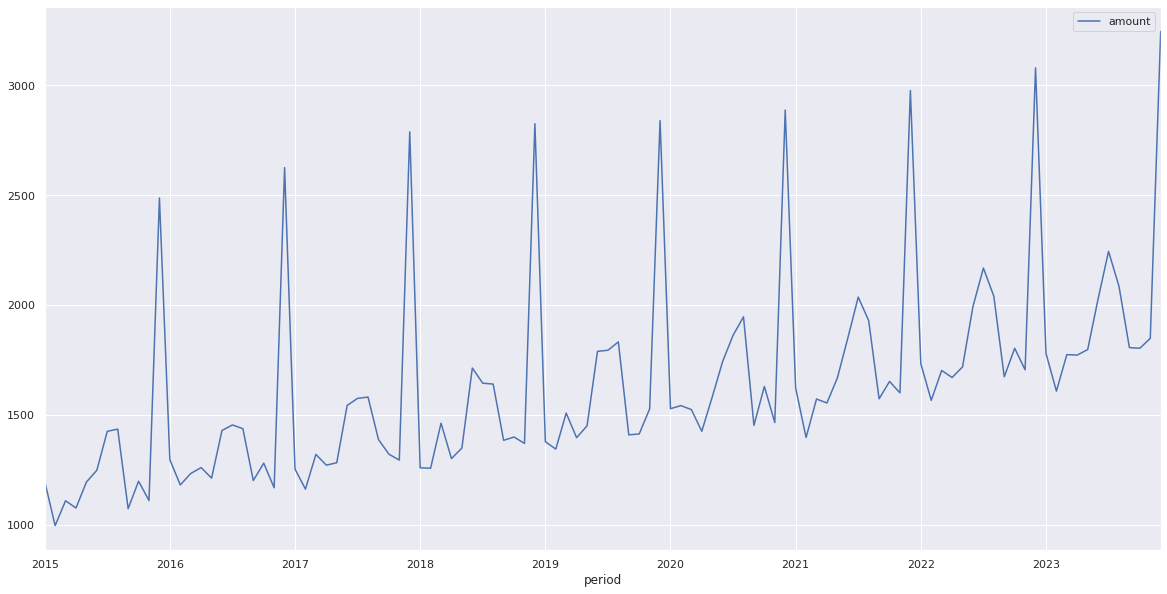

In [212]:
data.plot(x='period', y='amount')
plt.savefig('img/champagne.png', bbox_inches='tight')

In [168]:
train_data = data.head(-12)
test_data = data.tail(12)

In [206]:
champagne_chatgpt = \
  chat_gpt_forecast(
      data         = train_data.set_index('period'), 
      horizon      = 12, 
      time_idx     = 'period',
      forecast_col = 'forecast'
)

In [207]:
champagne_chatgpt

,period,forecast
0,2023-01,1745
1,2023-02,1555
2,2023-03,1750
3,2023-04,1755
4,2023-05,1781
5,2023-06,2039
6,2023-07,2220
7,2023-08,2038
8,2023-09,1740
9,2023-10,1797


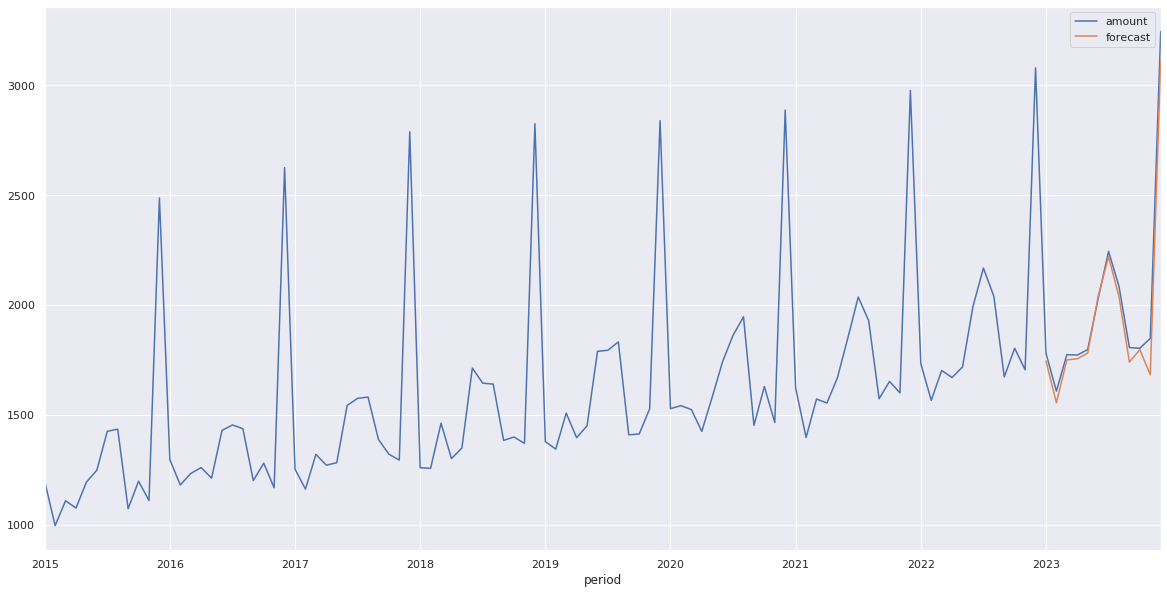

In [211]:
data \
    .merge(champagne_chatgpt, on='period', how='outer') \
    .plot(x='period', y=['amount', 'forecast'])
plt.savefig('img/champagne_chatgpt.png', bbox_inches='tight')

In [179]:
train_data

,period,amount
0,2015-01,1218
1,2015-02,965
2,2015-03,1090
3,2015-04,1019
4,2015-05,1205
...,...,...
91,2022-08,1988
92,2022-09,1690
93,2022-10,1747
94,2022-11,1632
